# This notebook presents the transformation of a TF model into a TFLite model to use it in an Android app


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jeremynadal33/classify_stanford_dogs/blob/master/tflite.ipynb)

This notebook presents :
* The conversion into tflite model
* The comparison of sizes
* The comparison in term of accuracy
* The addition of metadata important for the use in Android Studio

In [1]:
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras import backend as K
import os 
import shutil
import matplotlib.pyplot as plt 
from matplotlib import image
import numpy as np
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.4.1


In [3]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  from google.colab import drive
  drive.mount('/content/gdrive',force_remount=True)
  !ls /content/gdrive/My\ Drive/Formation-OC/P6-Images
  root_dir = '/content/gdrive/My Drive/Formation-OC/P6-Images/'
  input_dir = root_dir + 'inputs/'
  png_dir = root_dir + 'pngs/'

  baseline_species = os.listdir(input_dir+'baseline_inputs/train')

  model_dir = root_dir +'models/'

  #my script
  !ls gdrive/MyDrive/Formation-OC/P6-Images/
else:
  print('Not running on CoLab')
  #my script
  root_dir = '/Users/jeremynadal/Documents/Formation OC IML/P6-/'
  input_dir = root_dir + 'inputs/'
  png_dir = root_dir + 'pngs/'
  model_dir = root_dir +'models/'

Running on CoLab
Mounted at /content/gdrive
inputs					 models		       pngs
metadata_writer_for_image_classifier.py  P6-presentation.pptx
inputs					 models		       pngs
metadata_writer_for_image_classifier.py  P6-presentation.pptx


## We need a generator to access and evaluate the tflite models

In [4]:
batch_size = 16
input_shape = (442, 386, 3)

test_datagen = ImageDataGenerator()


validation_generator = test_datagen.flow_from_directory(input_dir+'sep_images/validation_clahe/',  # this is the target directory
                                                   target_size=input_shape[:-1],  # all images will be resized to 150x150
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   color_mode='rgb',
                                                   seed= 42)  #useless for the no augmentation 


STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

Found 6223 images belonging to 120 classes.


## Lets retrieve the model and convert it into a TFLite model
* Using a basic method
* Using size optimization


In [5]:
model_path = model_dir + 'final_1.h5'
tflite_model_path = model_dir+'tflite_model_1.tflite'
tflite_model_quant_path = model_dir+'tflite_model_1_optimized.tflite'

In [5]:
#Loading the original model and evaluating it 
model = tf.keras.models.load_model(model_path)
metrics = model.evaluate(validation_generator, steps= STEP_SIZE_VALID)

388/388 [==============================] - 1221s 3s/step - loss: 0.4160 - accuracy: 0.8711


In [30]:
#Converting both model
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]
tflite_model_quant = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmps8hun609/assets


INFO:tensorflow:Assets written to: /tmp/tmps8hun609/assets


INFO:tensorflow:Assets written to: /tmp/tmp_jmzvs1p/assets


INFO:tensorflow:Assets written to: /tmp/tmp_jmzvs1p/assets


In [31]:
#Saving the new tflite models
open(tflite_model_path,"wb").write(tflite_model)
open(tflite_model_quant_path,"wb").write(tflite_model_quant)

31437408

## Now we compare the different models in term of size

In [32]:
def get_file_size(file_path, units = None):
  size = os.path.getsize(file_path)
  if units : assert type(units)==str, 'units must be a string, either KB of MB'
  if units == 'KB':
    return print('File {} has size of : {} KB'.format(os.path.basename(file_path),round(size/1024,3)))
  elif units == 'MB':
    return print('File {} has size of : {} MB'.format(os.path.basename(file_path),round(size/(1024*1024),3)))
  else :
    return print('File {} has size of : {} Bytes'.format(os.path.basename(file_path),size))

In [33]:
get_file_size(model_path,units='MB')
get_file_size(tflite_model_path,units='MB')
get_file_size(tflite_model_quant_path,units='MB')

File final_1.h5 has size of : 347.626 MB
File tflite_model_1.tflite has size of : 115.563 MB
File tflite_model_1_optimized.tflite has size of : 29.981 MB


## The tflite models expect batch size of 1, lets change it to expect batchs

In [34]:
def get_details(interpreter):
  return interpreter.get_input_details(), interpreter.get_output_details()

In [35]:
def resize_interpreter(interpreter, input_shape, output_shape, batch_size):
  input_details, output_details = get_details(interpreter)

  print('Input shape was {} and its type was {}'.format(input_details[0]['shape'],input_details[0]['dtype']))
  print('Output shape was {} and its type was {}'.format(output_details[0]['shape'],output_details[0]['dtype']))
  print('\n')

  interpreter.resize_tensor_input(input_details[0]['index'], (batch_size,*input_shape))
  interpreter.resize_tensor_input(output_details[0]['index'], (batch_size,output_shape))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  print('Input shape is {} and its type is {}'.format(input_details[0]['shape'],input_details[0]['dtype']))
  print('Output shape is {} and its type is {}'.format(output_details[0]['shape'],output_details[0]['dtype']))
  
  return interpreter

In [36]:
interpreter = tf.lite.Interpreter(model_path = tflite_model_path)
interpreter_quant = tf.lite.Interpreter(model_path = tflite_model_quant_path)

In [37]:
interpreter = resize_interpreter(interpreter, input_shape, 120, batch_size)
interpreter_quant = resize_interpreter(interpreter_quant, input_shape, 120, batch_size)

Input shape was [  1 442 386   3] and its type was <class 'numpy.float32'>
Output shape was [  1 120] and its type was <class 'numpy.float32'>


Input shape is [ 16 442 386   3] and its type is <class 'numpy.float32'>
Output shape is [ 16 120] and its type is <class 'numpy.float32'>
Input shape was [  1 442 386   3] and its type was <class 'numpy.float32'>
Output shape was [  1 120] and its type was <class 'numpy.float32'>


Input shape is [ 16 442 386   3] and its type is <class 'numpy.float32'>
Output shape is [ 16 120] and its type is <class 'numpy.float32'>


## Now, we can display the predictions of a batch at once

In [17]:
def display_batch(img_batch, label_batch, interpreter, labels, save = None):
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  interpreter.set_tensor(input_details[0]['index'], img_batch)
  interpreter.invoke()
  predictions = interpreter.get_tensor(output_details[0]['index'])

  pred_ids = np.argmax(predictions, axis=-1)
  label_ids = np.argmax(label_batch, axis=-1)

  plt.figure(figsize=(10,9))
  plt.subplots_adjust(hspace=0.5)
  for n in range(16):
    plt.subplot(4,4,n+1)
    plt.imshow(img_batch[n]/255)
    color = "green" if pred_ids[n] == label_ids[n] else "red"
    plt.title(labels[label_ids[n]], color=color)
    plt.axis('off')
  if save != None : plt.savefig(png_dir+save)

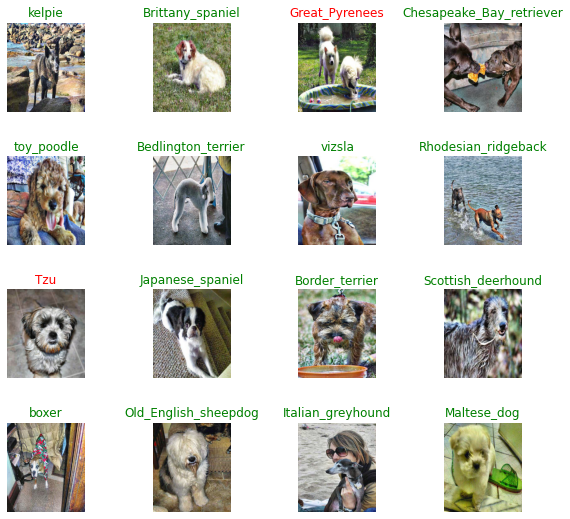

In [19]:
val_image_batch, val_label_batch = next(iter(validation_generator))
labels = [key.split('-')[-1] for key in validation_generator.class_indices.keys()]

display_batch(val_image_batch, val_label_batch, interpreter, labels, save = 'tflite.png')

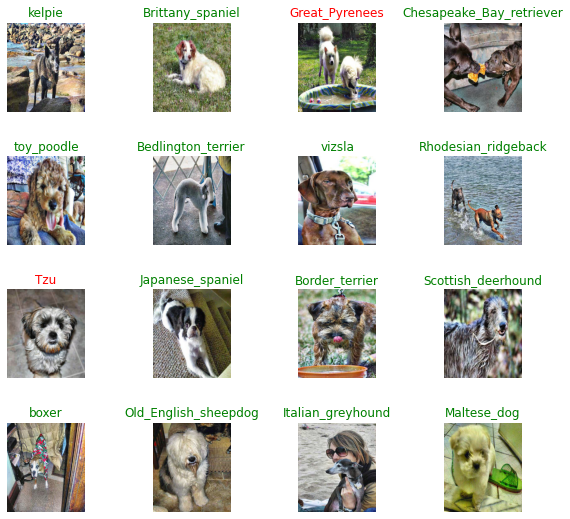

In [38]:
display_batch(val_image_batch, val_label_batch, interpreter_quant, labels, save = 'tflite_opt.png')

## Now, lets evaluate the models

In [14]:
from sklearn.metrics import accuracy_score

def evaluate_tflite_batch(interpreter, generator):
  batch_size = generator.batch_size
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  assert input_details[0]['shape'][0]==output_details[0]['shape'][0], 'Input and output of tflite model must have same batch_size'
  assert input_details[0]['shape'][0]==batch_size, 'tflite model must have same batch size as generator'
  
  STEP_SIZE = generator.n//generator.batch_size

  all_preds = []
  all_true = []
  num = 0
  for idx in range(STEP_SIZE):
    print('Managing step {} over {}'.format(idx+1,STEP_SIZE))
    
    img_batch, label_batch = next(iter(generator))
    if img_batch.shape[0]==batch_size:
      num += batch_size
      interpreter.set_tensor(input_details[0]['index'], img_batch)
      interpreter.invoke()
      predictions = interpreter.get_tensor(output_details[0]['index'])

      pred_ids = np.argmax(predictions, axis=-1)
      label_ids = np.argmax(label_batch, axis=-1)

      for idx in range(len(pred_ids)):
        all_preds.append(pred_ids[idx])
        all_true.append(label_ids[idx])

      if num%64==0:
        print('For {} images, the model got {:.3}% accuracy '.format(num,100*accuracy_score(all_true, all_preds)))
    else:
      print('Skipping one batch because shape is', img_batch.shape[0])
  print('For {} images, the model got {:.3}% accuracy '.format(num,100*accuracy_score(all_true, all_preds)))
  return all_preds, all_true

In [15]:
preds, true = evaluate_tflite_batch(interpreter, validation_generator)

Managing step 0 over 388
Managing step 1 over 388
Managing step 2 over 388
Managing step 3 over 388
For 64 images, the model got 89.1% accuracy 
Managing step 4 over 388
Managing step 5 over 388
Managing step 6 over 388
Managing step 7 over 388
For 128 images, the model got 88.3% accuracy 
Managing step 8 over 388
Managing step 9 over 388
Managing step 10 over 388
Managing step 11 over 388
For 192 images, the model got 85.9% accuracy 
Managing step 12 over 388
Managing step 13 over 388
Managing step 14 over 388
Managing step 15 over 388
For 256 images, the model got 85.5% accuracy 
Managing step 16 over 388
Managing step 17 over 388
Managing step 18 over 388
Managing step 19 over 388
For 320 images, the model got 85.0% accuracy 
Managing step 20 over 388
Managing step 21 over 388
Managing step 22 over 388
Managing step 23 over 388
For 384 images, the model got 85.9% accuracy 
Managing step 24 over 388
Managing step 25 over 388
Managing step 26 over 388
Managing step 27 over 388
For 448

In [ ]:
preds_quant, true_quant = evaluate_tflite_batch(interpreter_quant, validation_generator)

## We need to add metadata so android studio can easily use our model
### We need to use a metadata writer available on [GitHub](https://github.com/tensorflow/examples/blob/master/lite/examples/image_classification/metadata/metadata_writer_for_image_classifier.py) with explainations on [TensorFlow](https://www.tensorflow.org/lite/convert/metadata).

In [43]:
!pip install tflite_support

     |████████████████████████████████| 1.1MB 19.5MB/s 
     |████████████████████████████████| 194kB 55.3MB/s 


In [39]:
file_path = model_dir+'labels.txt'
f = open(file_path, "w+")

for key, ind in validation_generator.class_indices.items():
  f.write(key.split('-')[-1]+'\n')

f.close()

In [40]:
os.mkdir(model_dir+'model_with_metadata')

In [48]:
!python /content/gdrive/My\ Drive/Formation-OC/P6-Images/metadata_writer_for_image_classifier.py \
--model_file=/content/gdrive/My\ Drive/Formation-OC/P6-Images/models/tflite_model_1.tflite \
--label_file=/content/gdrive/My\ Drive/Formation-OC/P6-Images/models/labels.txt \
--export_directory =/content/gdrive/My\ Drive/Formation-OC/P6-Images/models/model_with_metadata

2021-03-02 21:42:29.826213: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
model_file: /content/gdrive/My Drive/Formation-OC/P6-Images/models/tflite_model_1.tflite
model_basename: tflite_model_1.tflite
Base export_model_path :  =/content/gdrive/My Drive/Formation-OC/P6-Images/models/model_with_metadata False
Base export_model_path :  /content/gdrive/My Drive/Formation-OC/P6-Images/models/model_with_metadata True
Finished populating metadata and associated file to the model:
/content/gdrive/My Drive/Formation-OC/P6-Images/models/tflite_model_1.tflite
The metadata json file has been saved to:
/content/gdrive/My Drive/Formation-OC/P6-Images/models/model_with_metadata/tflite_model_1.json
The associated file that has been been packed to the model is:
['labels.txt']
